In [12]:
# extract dataset
from zipfile import ZipFile

dataset_train = "train.zip"
    
with ZipFile(dataset_train, 'r') as zip:
    zip.extractall()

In [5]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [13]:
folder_path = f"Dataset/"
os.makedirs(folder_path, exist_ok=True)

# define path
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path dataset
dataset_dir = "Dataset/"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")

In [14]:
# load data, preprocessing data, and labeling
# dog = 1, cat = 0
train_images = os.listdir(train_dir)
features = []
labels = []
image_size = (50, 50)

# Proses train images
for image in tqdm(train_images, desc="Processing Train Images"):
    if image[0:3] == 'cat' :
        label = 0
    else :
        label = 1
    image_read = cv2.imread(train_dir+"/"+image)
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    image_flatten = image_normalized.flatten()
    features.append(image_flatten)
    labels.append(label)

Processing Train Images: 100%|██████████| 25000/25000 [05:07<00:00, 81.38it/s] 


In [15]:
del train_images

In [16]:
features = np.asarray(features)
labels = np.asarray(labels)

# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [17]:
del features
del labels

In [18]:
# PCA, SVM, & Pipeline
n_components = 0.8
pca = PCA(n_components=n_components)
svm = SVC()
pca = PCA(n_components=n_components, random_state=42)
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

In [19]:
param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

In [20]:
# Hitung waktu training
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)

# Hitung waktu training
end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.528 total time=  53.1s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.525 total time=  46.0s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.537 total time=  41.6s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.570 total time=  36.0s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.560 total time=  36.2s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.564 total time=  33.7s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.504 total time=  21.7s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.485 total time=  19.5s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.492 total time=  18.1s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.507 total time=  18.1s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.495 total time=  17.1s
[CV 3/

In [21]:
del X_train
del y_train

In [22]:
# Mendapatkan model terbaik dan parameter terbaik
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'pca__n_components': 0.9, 'svm__kernel': 'rbf'}
Best Score:  0.6738502183801701


In [23]:
# Evaluation on test dataset
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6846


In [24]:
y_pred = best_pipeline.predict(X_test)

# classification report
target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)

with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

Classification Report:
               precision    recall  f1-score   support

         Cat       0.69      0.69      0.69      2515
         Dog       0.68      0.68      0.68      2485

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



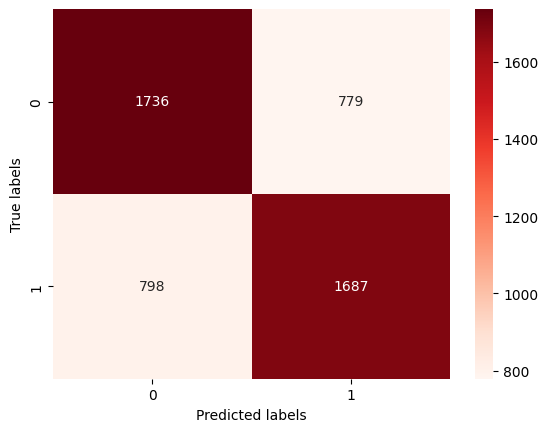

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()